## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)  # download dataset, and get the path where it's downloaded
path.ls()

[PosixPath('/home/zcr/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/zcr/.fastai/data/camvid/images'),
 PosixPath('/home/zcr/.fastai/data/camvid/labels'),
 PosixPath('/home/zcr/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/zcr/.fastai/data/camvid/images/0001TP_006690.png'),
 PosixPath('/home/zcr/.fastai/data/camvid/images/0001TP_006720.png'),
 PosixPath('/home/zcr/.fastai/data/camvid/images/0001TP_006750.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/zcr/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 PosixPath('/home/zcr/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 PosixPath('/home/zcr/.fastai/data/camvid/labels/0001TP_006750_P.png')]

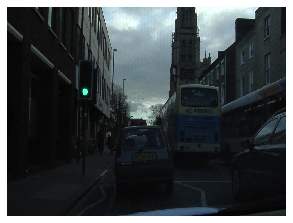

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'  # get the label file's path

In [9]:
get_y_fn(img_f)

PosixPath('/home/zcr/.fastai/data/camvid/labels/0001TP_006690_P.png')

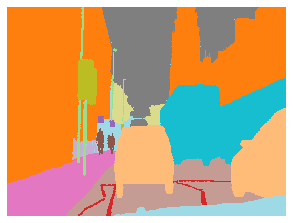

In [10]:
mask = open_mask(get_y_fn(img_f))  # get integers of the mask
mask.show(figsize=(5,5), alpha=1)  # show the mask

In [11]:
mask.shape

torch.Size([1, 720, 960])

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [16]:
size = src_size//2  # array([360, 480])

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7181MB of GPU RAM free


In [14]:
src = (SegmentationItemList.from_folder(path_img)
       # Where to find the data? -> in path and its subfolders
       .split_by_fname_file('../valid.txt')
       # How to split in train/valid? -> use txt file
       .label_from_func(get_y_fn, classes=codes))
       # How to label? -> depending on the one-to-one file
       # in the label folder，the filename of which can be got by func

get_transforms(do_flip:bool=True, （水平反転）

flip_vert:bool=False, （垂直反転）

max_rotate:float=10.0, （回転角度）

max_zoom:float=1.1, （ズームイン・ズームアウト）

max_lighting:float=0.2, （光度）

max_warp:float=0.2, （歪み）

p_affine:float=0.75, （アフィン変換の発生率）

p_lighting:float=0.75, （光度変換の発生率）

xtra_tfms:Optional[Collection[Transform]]=None)  # a list of additional transforms you would like to be applied

This function returns a tuple of two lists of transforms, one for the training set and the other for the validation set (which is limited to a center crop by default).

(from [docs.fast.ai](https://docs.fast.ai/))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Data augmentation? -> use tfms with a size of [360, 480]
        .databunch(bs=bs)
        # Finally -> use the defaults for conversion to databunch and bunchsize=4
        .normalize(imagenet_stats))
        # normalized by the stats from imagenet (not yet thoroughly understood)
# There are 600 imgs for train, so we have 150 bunches

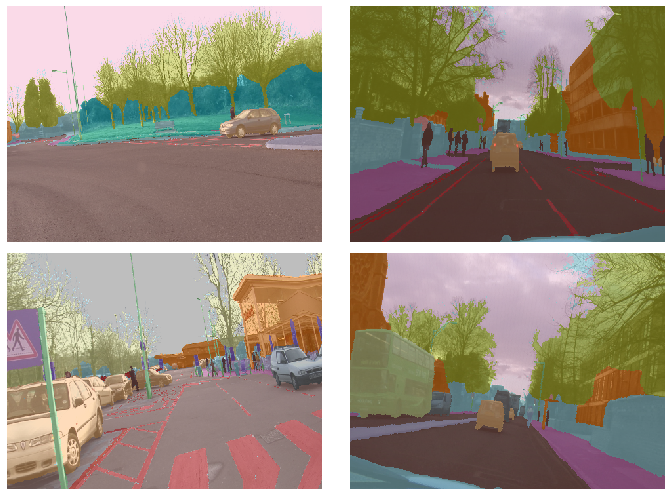

In [18]:
data.show_batch(2, figsize=(10,7))

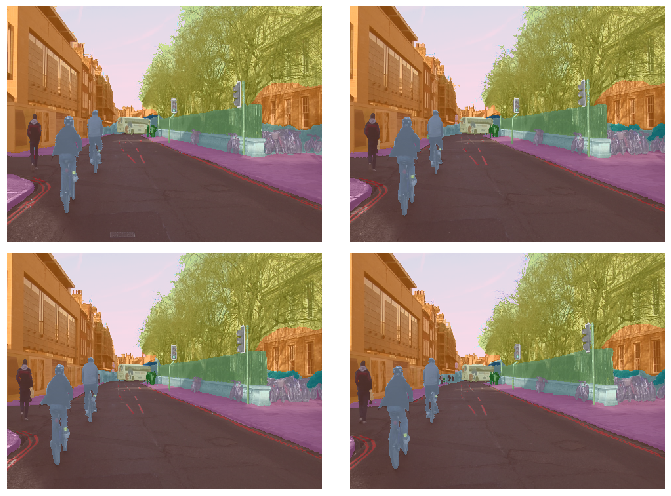

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)  # show valid imgs

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):  # define the loss fuction for segmentation
    target = target.squeeze(1)  # delete axis1
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2  # weight decay(L2)

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)  # use unet+resnet34

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


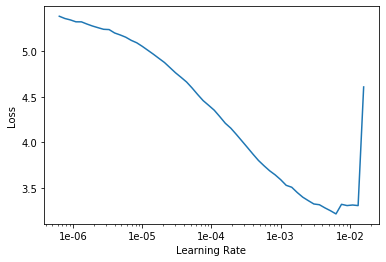

In [25]:
lr_find(learn)
learn.recorder.plot()  # to find most suitable lr

In [26]:
lr=3e-3  # choose the lr little bigger than where the gradient is steepest

1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our momentum from mom_max to mom_min.
- We do the exact opposite: we progressively decrease our learning rate from lr_max to lr_max/div_factor and at the same time we progressively increase our momentum from mom_min to mom_max.
- We further decrease our learning rate from lr_max/div_factor to lr_max/(div_factor x 100) and we keep momentum steady at mom_max.

(from [docs.fast.ai](https://docs.fast.ai/))

default:
moms: (0.95, 0.85),
div_factor: float = 25.0

pct_start: when to decrease

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.937142,0.683448,0.830667,00:52
1,0.734989,0.577382,0.842438,00:51
2,0.632390,0.506920,0.862041,00:51
3,0.611210,0.514628,0.863667,00:51
4,0.602718,0.470701,0.872382,00:51
5,0.576735,0.462959,0.879239,00:51
6,0.601019,0.461549,0.873536,00:51
7,0.529469,0.369033,0.896947,00:51
8,0.498654,0.390956,0.891161,00:51
9,0.425988,0.345059,0.895847,00:51


In [28]:
learn.save('stage-1')

In [29]:
learn.load('stage-1');
# If the next training is going bad, we can stop it immediately and load the previous model

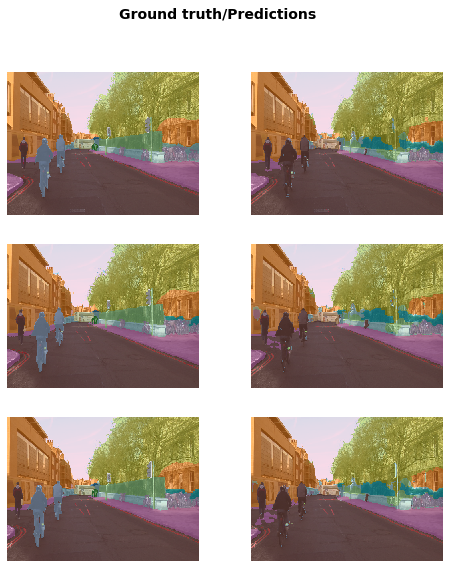

In [30]:
learn.show_results(rows=3, figsize=(8,9))

In [31]:
learn.unfreeze()
# The former training just trained the params of the last layer.
# Now we train all.

In [32]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


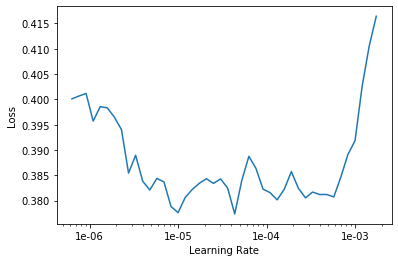

In [33]:
learn.recorder.plot(skip_end=15)

In [34]:
lrs = slice(1e-6,3e-5)

In [35]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.388438,0.335768,0.898632,00:53
1,0.380243,0.330297,0.899559,00:53
2,0.372576,0.326216,0.900265,00:53
3,0.374666,0.319806,0.902273,00:53
4,0.384852,0.317926,0.901897,00:53
5,0.375821,0.315957,0.902807,00:53
6,0.379674,0.312663,0.904178,00:53
7,0.368051,0.310273,0.904925,00:53
8,0.361693,0.311972,0.904493,00:53
9,0.358068,0.309278,0.906594,00:54


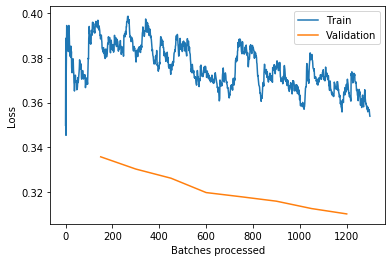

In [36]:
learn.recorder.plot_losses(skip_end=500)

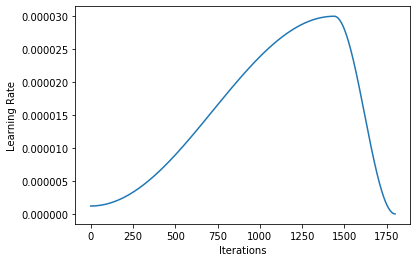

In [37]:
learn.recorder.plot_lr()  # decreased when 12*150*0.8=1440

In [38]:
learn.save('stage-2');

In [39]:
learn.load('stage-2');

In [43]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [44]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________

## Go big

In [59]:
learn.destroy()

size = src_size  # array([720, 960])

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 4985MB of GPU RAM free


In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [62]:
learn.load('stage-2');

In [63]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 360, 480]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 360, 480]       128        True      
______________________________________________________________________
ReLU                 [64, 360, 480]       0          False     
______________________________________________________________________
MaxPool2d            [64, 180, 240]       0          False     
______________________________________________________________________
Conv2d               [64, 180, 240]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
__________________________________________________

In [64]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


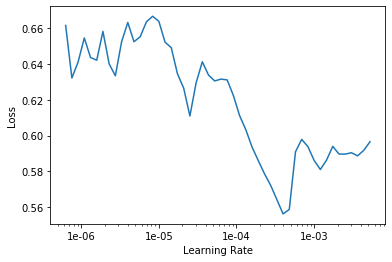

In [67]:
learn.recorder.plot(skip_end=5)

In [68]:
lrs = slice(3e-6,3e-4)

In [69]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.554266,0.401675,0.888609,03:34
1,0.512299,0.385855,0.892762,03:38
2,0.438910,0.349248,0.904012,03:36
3,0.428035,0.340068,0.904770,03:40
4,0.388928,0.307474,0.909989,03:34
5,0.395189,0.281440,0.922770,03:34
6,0.350645,0.334137,0.900151,03:34
7,0.365136,0.290543,0.915603,03:35
8,0.329104,0.291714,0.916961,03:36
9,0.261467,0.287730,0.918900,03:35


In [70]:
learn.save('stage-1-big')

In [71]:
learn.load('stage-1-big');

In [82]:
learn.unfreeze()

In [96]:
lr_find(learn, start_lr=1e-07, end_lr=1e-03)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


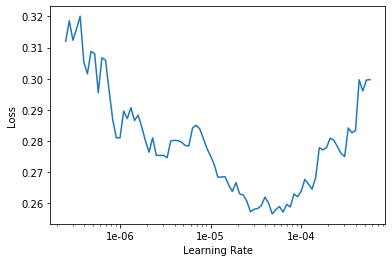

In [97]:
learn.recorder.plot()

In [98]:
lrs = slice(3e-5,3e-7)

In [99]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.278238,0.294985,0.917020,03:48
1,0.295807,0.289113,0.919351,03:46
2,0.277761,0.291885,0.916291,03:50
3,0.277228,0.290226,0.917781,03:49
4,0.283605,0.291517,0.917968,03:45
5,0.274060,0.288917,0.918200,03:47
6,0.266401,0.296379,0.917112,03:48
7,0.263269,0.285596,0.919862,03:50
8,0.262863,0.282796,0.920613,03:49
9,0.261826,0.286019,0.919397,03:46


The original notebook shows that Mr. Jeremy had a acc_camvid of 0.933. Maybe my tuning isn't so good, or just not lucky

In [100]:
learn.save('stage-2-big')

In [31]:
learn.load('stage-2-big');

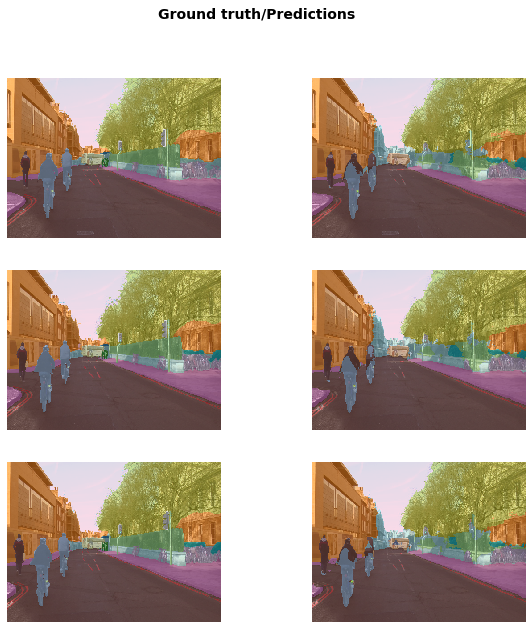

In [24]:
learn.show_results(rows=3, figsize=(10,10))

In [32]:
learn.export('segmentation.pkl')

## fin